# EYE BLINK DETECTION:

# 3) Machine Learning Model - part2

For this part we will implement the ML model described in [the paper by Soukupova and Cech (2016)](http://http://vision.fe.uni-lj.si/cvww2016/proceedings/papers/05.pdf).

We will use the output dataframes of part-1. 

In [1]:
# import sklearn methods 
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC,SVC
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

Read training set.

In [2]:
# read dataset
df = pd.read_pickle('../input/eye-blink-detection-3-ml-model-part1/train/training_set.pkl')
df.head()

,subject,external_factors,facial_actions,frame_no,face_detected,left_ear,right_ear,avg_ear,mar,moe,...,right_sop,avg_sop,closeness,blink_no,blink_start_frame,blink_end_frame,reserved_for_calibration,perclos,closeness_annot,blink_annot
0,1,None,26122013_223310_cam,1,1,0.258551,0.251491,0.255021,0.000000,0.000000,...,0.421133,0.417291,0,0,1,1,True,-1.0,0,0
1,1,None,26122013_223310_cam,2,1,0.269800,0.239934,0.254867,0.032141,0.126110,...,0.468100,0.432625,0,0,1,1,True,-1.0,0,0
2,1,None,26122013_223310_cam,3,1,0.230599,0.293610,0.262104,0.022217,0.084763,...,0.415718,0.428555,0,0,1,1,True,-1.0,0,0
3,1,None,26122013_223310_cam,4,1,0.269800,0.293610,0.281705,0.023256,0.082554,...,0.468100,0.454746,0,0,1,1,True,-1.0,0,0
4,1,None,26122013_223310_cam,5,1,0.258551,0.281942,0.270246,0.000000,0.000000,...,0.450859,0.437356,0,0,1,1,True,-1.0,0,0


construct (n x 13) matrix of training set. Columns are defining 13 frame window (6 previous frames + current frame + 6 next frames).

In [3]:
# only get necessary columns
ear = df[['subject','frame_no','avg_ear','blink_annot']]

# group by subject
user_list = list(ear['subject'].unique())
list_of_dfs=[]
for user in user_list:
    list_of_dfs.append(ear.groupby('subject').get_group(user))


# construct a df with columns depicting 13 frame window (6 previous frames + current frame + 6 next frames)
list_of_13dfs = []
for subject_df in list_of_dfs:
    for i in range(-6,7):
        subject_df['ear'+str(i)] = subject_df.shift(periods=i*(-1))['avg_ear']
    subject_df=subject_df[6:-6]
    list_of_13dfs.append(subject_df)
    
# concat results
ear13_df = pd.concat(list_of_13dfs)
ear13_df.drop(columns=['frame_no', 'avg_ear'],inplace=True)
ear13_df.reset_index(drop=True, inplace=True)
ear13_df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,subject,blink_annot,ear-6,ear-5,ear-4,ear-3,ear-2,ear-1,ear0,ear1,ear2,ear3,ear4,ear5,ear6
0,1,0,0.255021,0.254867,0.262104,0.281705,0.270246,0.294951,0.304514,0.295574,0.294976,0.298302,0.300481,0.295888,0.294953
1,1,0,0.254867,0.262104,0.281705,0.270246,0.294951,0.304514,0.295574,0.294976,0.298302,0.300481,0.295888,0.294953,0.256632
2,1,0,0.262104,0.281705,0.270246,0.294951,0.304514,0.295574,0.294976,0.298302,0.300481,0.295888,0.294953,0.256632,0.256280
3,1,0,0.281705,0.270246,0.294951,0.304514,0.295574,0.294976,0.298302,0.300481,0.295888,0.294953,0.256632,0.256280,0.267013
4,1,0,0.270246,0.294951,0.304514,0.295574,0.294976,0.298302,0.300481,0.295888,0.294953,0.256632,0.256280,0.267013,0.266355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71255,11,0,0.253677,0.247394,0.251768,0.227690,0.245400,0.271400,0.229162,0.249375,0.242212,0.236984,0.255580,0.231446,0.249920
71256,11,0,0.247394,0.251768,0.227690,0.245400,0.271400,0.229162,0.249375,0.242212,0.236984,0.255580,0.231446,0.249920,0.227307
71257,11,0,0.251768,0.227690,0.245400,0.271400,0.229162,0.249375,0.242212,0.236984,0.255580,0.231446,0.249920,0.227307,0.254391
71258,11,0,0.227690,0.245400,0.271400,0.229162,0.249375,0.242212,0.236984,0.255580,0.231446,0.249920,0.227307,0.254391,0.262248


Some analysis on the dataframe.

In [4]:
# df info
print(ear13_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71260 entries, 0 to 71259
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   subject      71260 non-null  object 
 1   blink_annot  71260 non-null  int64  
 2   ear-6        71260 non-null  float64
 3   ear-5        71260 non-null  float64
 4   ear-4        71260 non-null  float64
 5   ear-3        71260 non-null  float64
 6   ear-2        71260 non-null  float64
 7   ear-1        71260 non-null  float64
 8   ear0         71260 non-null  float64
 9   ear1         71260 non-null  float64
 10  ear2         71260 non-null  float64
 11  ear3         71260 non-null  float64
 12  ear4         71260 non-null  float64
 13  ear5         71260 non-null  float64
 14  ear6         71260 non-null  float64
dtypes: float64(13), int64(1), object(1)
memory usage: 8.2+ MB
None


TOTAL COUNT: 71260
POSITIVE COUNT: 3709
NEGATIVE COUNT: 67551



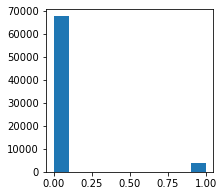

In [5]:
# number of classes
plt.figure(figsize =(3,3))
plt.hist(ear13_df.blink_annot)
total_count = len(ear13_df)
pos_count = ear13_df.loc[ear13_df['blink_annot'] == 1, 'blink_annot'].count()
neg_count = ear13_df.loc[ear13_df['blink_annot'] == 0, 'blink_annot'].count()
print("TOTAL COUNT: {}\nPOSITIVE COUNT: {}\nNEGATIVE COUNT: {}\n".format(total_count,pos_count,neg_count))

In [6]:
# Look for missing values
print(ear13_df.isnull().sum())  

subject        0
blink_annot    0
ear-6          0
ear-5          0
ear-4          0
ear-3          0
ear-2          0
ear-1          0
ear0           0
ear1           0
ear2           0
ear3           0
ear4           0
ear5           0
ear6           0
dtype: int64


Now implement SVM:

In [7]:
# split df to X and Y (no train-test split. we will use all of eyeblink8 videos as training set, talkingFace as test set)
y = ear13_df.loc[:, 'blink_annot'].values
X = ear13_df.drop(columns=['blink_annot'])

# normalize for each subject
f = lambda x: (StandardScaler().fit_transform(x.to_frame()))[:, 0]
norm_X = X.groupby('subject').transform(f)

# normalize for all dataset
norm_X = StandardScaler().fit_transform(norm_X)

# cross-validation with 5 splits
cv = StratifiedShuffleSplit(n_splits=10, random_state = 42)

# SVM classifier
svm = SVC(tol=1e-5)

# parameters 
parameters = {
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'C': [0.01,0.1,1,10,100],
                'gamma': ['scale', 'auto'],
                #'degree': [2,3,4],
                'max_iter': [100,1000,5000],
                'class_weight': [None, 'balanced'],
    
            }
4
# grid search for parameters
grid = GridSearchCV(estimator=svm, param_grid=parameters, cv=cv, n_jobs=-1)
grid.fit(norm_X, y)

# print best scores
print("The best parameters are %s with a score of %0.4f\n"
      % (grid.best_params_, grid.best_score_))

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


The best parameters are {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 5000} with a score of 0.9779



/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Read test set and construct its (n x 13) matrix, then do some analysis again.

In [8]:
# read dataset
df_test = pd.read_pickle("../input/eye-blink-detection-3-ml-model-part1/test/test_set.pkl")

# only get necessary columns
ear_test = df_test[['subject','frame_no','avg_ear','blink_annot']]

# group by subject
user_list_test = list(ear_test['subject'].unique())
list_of_dfs_test=[]
for user in user_list_test:
    list_of_dfs_test.append(ear_test.groupby('subject').get_group(user))


    
# construct a df with columns depicting 13 frame window (6 previous frames + current frame + 6 next frames)
list_of_13dfs_test = []
for subject_df in list_of_dfs_test:
    for i in range(-6,7):
        subject_df['ear'+str(i)] = subject_df.shift(periods=i*(-1))['avg_ear']
    subject_df=subject_df[6:-6]
    list_of_13dfs_test.append(subject_df)
    
# concat results
ear13_df_test = pd.concat(list_of_13dfs_test)
ear13_df_test.drop(columns=['frame_no', 'avg_ear'],inplace=True)
ear13_df_test.reset_index(drop=True, inplace=True)

# df info
print(ear13_df_test.info())
print()

# Look for missing values
print("MISSING VALUES:")
print(ear13_df_test.isnull().sum())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4988 entries, 0 to 4987
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   subject      4988 non-null   object 
 1   blink_annot  4988 non-null   int64  
 2   ear-6        4988 non-null   float64
 3   ear-5        4988 non-null   float64
 4   ear-4        4988 non-null   float64
 5   ear-3        4988 non-null   float64
 6   ear-2        4988 non-null   float64
 7   ear-1        4988 non-null   float64
 8   ear0         4988 non-null   float64
 9   ear1         4988 non-null   float64
 10  ear2         4988 non-null   float64
 11  ear3         4988 non-null   float64
 12  ear4         4988 non-null   float64
 13  ear5         4988 non-null   float64
 14  ear6         4988 non-null   float64
dtypes: float64(13), int64(1), object(1)
memory usage: 584.7+ KB
None

MISSING VALUES:
subject        0
blink_annot    0
ear-6          0
ear-5          0
ear-4          0
ear-3  

Prepare test set for predictions.

In [9]:
# split df to X_test and y_test
y_test = ear13_df_test.loc[:, 'blink_annot'].values
X_test = ear13_df_test.drop(columns=['blink_annot'])

# normalize for each subject
f = lambda x: (StandardScaler().fit_transform(x.to_frame()))[:, 0]
norm_X_test = X_test.groupby('subject').transform(f)

Implement a utility function to print results

In [10]:
# display test scores and return result string and indexes of false samples
def display_test_scores_v2(test, pred):
    str_out = ""
    str_out += ("TEST SCORES\n")
    str_out += ("\n")

    #print accuracy
    accuracy = accuracy_score(test, pred)
    str_out += ("ACCURACY: {:.4f}\n".format(accuracy))
    str_out += ("\n")

    #print AUC score
    auc = roc_auc_score(test, pred)
    str_out += ("AUC: {:.4f}\n".format(auc))
    str_out += ("\n")

    #print confusion matrix
    str_out += ("CONFUSION MATRIX:\n")
    conf_mat = confusion_matrix(test, pred)
    str_out += ("{}".format(conf_mat))
    str_out += ("\n")
    str_out += ("\n")

    #print FP, FN
    str_out += ("FALSE POSITIVES:\n")
    fp = conf_mat[1][0]
    pos_labels = conf_mat[1][0]+conf_mat[1][1]
    str_out += ("{} out of {} positive labels ({:.4f}%)\n".format(fp, pos_labels,fp/pos_labels))
    str_out += ("\n")

    str_out += ("FALSE NEGATIVES:\n")
    fn = conf_mat[0][1]
    neg_labels = conf_mat[0][1]+conf_mat[0][0]
    str_out += ("{} out of {} negative labels ({:.4f}%)\n".format(fn, neg_labels, fn/neg_labels))
    str_out += ("\n")

    #print classification report
    str_out += ("PRECISION, RECALL, F1 scores:\n")
    str_out += ("{}".format(classification_report(test, pred)))
    
    false_indexes = np.where(test != pred)
    return str_out, false_indexes

In [11]:
# prediction results
y_pred = grid.predict(norm_X_test)

# print accuracy metrics
results, false = display_test_scores_v2(y_test, y_pred)
print(results)

TEST SCORES

ACCURACY: 0.9753

AUC: 0.9278

CONFUSION MATRIX:
[[4471   64]
 [  59  394]]

FALSE POSITIVES:
59 out of 453 positive labels (0.1302%)

FALSE NEGATIVES:
64 out of 4535 negative labels (0.0141%)

PRECISION, RECALL, F1 scores:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4535
           1       0.86      0.87      0.86       453

    accuracy                           0.98      4988
   macro avg       0.92      0.93      0.93      4988
weighted avg       0.98      0.98      0.98      4988



Try another SVM implementation by https://github.com/rezaghoddoosian/Early-Drowsiness-Detection and compare results.

In [12]:
from sklearn.externals import joblib 

# load the file "Trained_SVM_C1000_gamma0.1_for 7kNegSample.sav" 
svm2 = joblib.load("../input/rldd-blink-svm/Trained_SVM_C1000_gamma0.1_for 7kNegSample.sav")  

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.svm.classes module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.svm. Anything that cannot be imported from sklearn.svm is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version pre-0.18 when using version 0.22.2.post1. This 

It's an old version of SVC (scikit<0.18) and its predict() method gives error so we use manual implementation of rbf prediction method based on its parameters. (see https://stackoverflow.com/questions/28593684/replication-of-scikit-svm-srv-predictx)

In [13]:
# define decision function and predict methods
def rbf_decision_function(sup_vecs, dual_coefs, gamma, intercept,Xtest):
    diff = sup_vecs - Xtest
    norm2 = np.array([np.linalg.norm(diff[n, :]) for n in range(np.shape(sup_vecs)[0])])
    dec_func_vec = (dual_coefs.dot(np.exp(-gamma*(norm2**2))) + intercept)
    return dec_func_vec

def rbf_predict(sup_vecs, dual_coefs, gamma, intercept,Xtest):
    list_predictions=[]
    for row in Xtest:
        dec = rbf_decision_function(sup_vecs, dual_coefs, gamma, intercept,row)
        list_predictions.append(1 if dec[0]>0 else 0)
    return np.array(list_predictions)

In [14]:
# get parameters from old model
sup_vecs = svm2.support_vectors_
dual_coefs = svm2.dual_coef_
gamma = svm2.gamma
intercept = svm2.intercept_/10 # ---> after some tryouts, apperantly, they did intercept scaling BY 10

# prediction results
y_pred2 = rbf_predict(sup_vecs, dual_coefs, gamma, intercept, np.array(norm_X_test))
#y_pred2= np.apply_along_axis(rbf_decision_function,1,np.array(norm_X_test),sup_vecs, dual_coefs, gamma, intercept)

# print accuracy metrics
results2, false2 = display_test_scores_v2(y_test, (y_pred2>0).astype(int))
print(results2)

TEST SCORES

ACCURACY: 0.9094

AUC: 0.9372

CONFUSION MATRIX:
[[4096  439]
 [  13  440]]

FALSE POSITIVES:
13 out of 453 positive labels (0.0287%)

FALSE NEGATIVES:
439 out of 4535 negative labels (0.0968%)

PRECISION, RECALL, F1 scores:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      4535
           1       0.50      0.97      0.66       453

    accuracy                           0.91      4988
   macro avg       0.75      0.94      0.80      4988
weighted avg       0.95      0.91      0.92      4988



**NOTE:** Or alternatively, instead of using manual predictions, you can assign missing attributes like this:

> svm2._n_support = np.array([956, 961])  
> svm2.break_ties = False  

Then you can use original predict() method.

In [15]:
# print predictions
pred_df=pd.Series(y_pred,name='predictions')
pred_df.to_pickle("red_df_ml.pkl")

pred_df=pd.Series(y_pred2,name='predictions')
pred_df.to_pickle("red_df_ml2.pkl")